In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import threadpoolctl

## Part II: Airline Safety Records

In this section of the assignment, we analyse the airline safety dataset. The premise of the dataset is about people's reactions to high profile airline accidents - and why they would avoid travelling with certain particular airlines. Hence, we will use the dataset to investigate which airlines are similar based on their past safety records.

The main modelling that we will do here is using K-means clustering. Given that the dataset does not have a target variable, this is an unsupervised learning problem. We will use the K-means algorithm to cluster the airlines based on their safety records. We will then use the clusters to identify which airlines are similar to each other.

**Loading in the Dataset**

In [3]:
# Load the data
airline = pd.read_csv('../datasets/airline-safety.csv')
airline.head(5)

,airline,avail_seat_km_per_week,incidents_85_99,fatal_accidents_85_99,fatalities_85_99,incidents_00_14,fatal_accidents_00_14,fatalities_00_14
0,Aer Lingus,320906734,2,0,0,0,0,0
1,Aeroflot*,1197672318,76,14,128,6,1,88
2,Aerolineas Argentinas,385803648,6,0,0,1,0,0
3,Aeromexico*,596871813,3,1,64,5,0,0
4,Air Canada,1865253802,2,0,0,2,0,0


The description of the features in the airline data is:
- **airline** - the name of the airline (and regional subsidaries)
- **avail_seat_km_per_week** - the number of available seat kilometers flown by the airline per week
- **incidents_85_99** - the number of incidents that occured between 1985 and 1999
- **fatal_accidents_85_99** - the number of fatal accidents that occured between 1985 and 1999
- **fatalities_85_99** - the total number of fatalities that occured between 1985 and 1999
- **incidents_00_14** - the number of incidents that occured between 2000 and 2014
- **fatal_accidents_00_14** - the number of fatal accidents that occured between 2000 and 2014
- **fatalities_00_14** - the total number of fatalities that occured between 2000 and 2014

We can see that the data is somewhat broken down into 3 components:
- The name of the airline and the number of available seat kilometers flown by the airline per week
- The number of incidents, fatal accidents and fatalities that occured between 1985 and 1999
- The number of incidents, fatal accidents and fatalities that occured between 2000 and 2014

The variables in the second and third components are closely related to each other. For example, the number of incidents that occured between is related to the number of fatal accidents. Therefore, fatal accidents cannot be more than the number of incidents. We might consider just using one of the variables in each component to avoid redundancy. However, we will keep all the variables for now.

In [4]:
airline.head(10)

,airline,avail_seat_km_per_week,incidents_85_99,fatal_accidents_85_99,fatalities_85_99,incidents_00_14,fatal_accidents_00_14,fatalities_00_14
0,Aer Lingus,320906734,2,0,0,0,0,0
1,Aeroflot*,1197672318,76,14,128,6,1,88
2,Aerolineas Argentinas,385803648,6,0,0,1,0,0
3,Aeromexico*,596871813,3,1,64,5,0,0
4,Air Canada,1865253802,2,0,0,2,0,0
5,Air France,3004002661,14,4,79,6,2,337
6,Air India*,869253552,2,1,329,4,1,158
7,Air New Zealand*,710174817,3,0,0,5,1,7
8,Alaska Airlines*,965346773,5,0,0,5,1,88
9,Alitalia,698012498,7,2,50,4,0,0


Before we analyse the data, we will load in the dataset and do some basic data cleaning. It is good practice once again to check if there are any missing or invalid data in the dataset. 

More importantly, as we have looked at the dataset, we can see that the variable avail_seat_km_per_week is a extremely large in comparison to the other variables. We can either use a different metric to scale down the variable, or perform scaling on the dataset.

In [5]:
# Check for missing values
null_count = np.array(airline.isnull().sum())
na_counts = np.array(airline.isna().sum())
pd.DataFrame(np.vstack((null_count, na_counts)), columns=airline.columns, index=['null_count','na_counts'])

,airline,avail_seat_km_per_week,incidents_85_99,fatal_accidents_85_99,fatalities_85_99,incidents_00_14,fatal_accidents_00_14,fatalities_00_14
null_count,0,0,0,0,0,0,0,0
na_counts,0,0,0,0,0,0,0,0


In [6]:
# Before scaling the data, we need to remove the 'airline' column and store it first
airline_name = airline['airline']
airline = airline.drop('airline', axis=1)

# Scaling the data using StandardScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
airline_scaled = pd.DataFrame(scaler.fit_transform(airline), columns=airline.columns)

In [7]:
airline_scaled.head(5)

,avail_seat_km_per_week,incidents_85_99,fatal_accidents_85_99,fatalities_85_99,incidents_00_14,fatal_accidents_00_14,fatalities_00_14
0,-0.732498,-0.473505,-0.768345,-0.773244,-0.915809,-0.776414,-0.503179
1,-0.128737,6.292717,4.169215,0.107235,0.416277,0.398699,0.294398
2,-0.687808,-0.107763,-0.768345,-0.773244,-0.693795,-0.776414,-0.503179
3,-0.542462,-0.382069,-0.415662,-0.333005,0.194263,-0.776414,-0.503179
4,0.330974,-0.473505,-0.768345,-0.773244,-0.471780,-0.776414,-0.503179


### K-Means Clustering

We want to figure out what is the optimal number of clusters, where optimal in a sense being that the within cluster distances (meausured by Euclidan distances) are minimised. We can determine the k-number of clusters by using a elbow/scree plot. Alternatively, we can also use the silhouette score to determine the optimal number of clusters.

The silhouette score calculates the mean siluhouette coefficient of all samples. 

In [38]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Test using kmeans = 5
kmeans = KMeans(n_clusters=5, random_state=5508, n_init='auto')
kmeans.fit_predict(airline_scaled.values)

array([1, 3, 1, 1, 4, 3, 0, 1, 1, 1, 4, 3, 1, 0, 4, 4, 0, 1, 1, 2, 0, 1,
       0, 1, 0, 1, 1, 1, 0, 3, 4, 0, 1, 4, 3, 0, 1, 4, 1, 1, 0, 4, 1, 4,
       1, 1, 1, 3, 1, 0, 0, 2, 0, 1, 1, 1], dtype=int32)

In [40]:
kmeans.

array([[-0.19278785,  0.21577756,  0.47960996,  1.33482507,  0.14302845,
         0.48909217, -0.03955265],
       [-0.55840154, -0.35745223, -0.44279142, -0.47348972, -0.45470237,
        -0.50523382, -0.38047481],
       [ 3.75151386,  1.30948593,  2.75848395,  1.72373842,  3.30246277,
         1.57381143,  0.22189073],
       [ 0.45312339,  1.23328974,  0.81872811, -0.26880312,  0.60128874,
         1.57381143,  2.28984973],
       [ 0.75587935, -0.39222895, -0.57240991, -0.76407237, -0.02775179,
        -0.64584558, -0.41959449]])

In [39]:
silhouette_score(airline_scaled.values, kmeans.labels_)

0.2344114404914845

In [34]:
# PCA for the scaled data
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
airline_pca = pca.fit_transform(airline_scaled.values)

kmeans = KMeans(n_clusters=2, random_state=5508, n_init='auto')
cluser_ind = kmeans.fit_predict(airline_pca)

In [35]:
airline_pca = pd.DataFrame(airline_pca, columns=['PC1', 'PC2'])
airline_pca['Cluster'] = cluser_ind

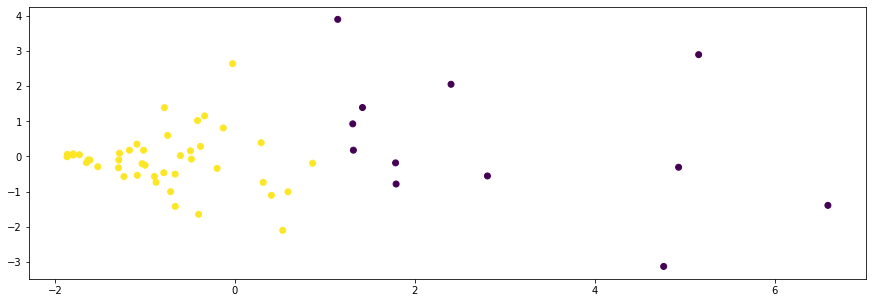

In [36]:
plt.figure(figsize=(15, 5))
plt.scatter(airline_pca['PC1'], airline_pca['PC2'], c=airline_pca['Cluster'])
plt.show()

In [37]:
pca.components_.T

array([[ 0.36683367,  0.05875213],
       [ 0.38622022, -0.31374422],
       [ 0.46285552, -0.35729859],
       [ 0.26497288, -0.42897569],
       [ 0.43504853,  0.08181854],
       [ 0.41280578,  0.41623156],
       [ 0.26859879,  0.6375636 ]])